# Theano, Lasagne
и с чем их едят

# разминка
* напиши на numpy функцию, которая считает сумму квадратов чисел от 0 до N, где N - аргумент
* массив чисел от 0 до N - numpy.arange(N)

In [1]:
import numpy as np
def sum_squares(N):
    return np.sum(np.arange(N)**2)

In [2]:
%%time
sum_squares(10**8)

CPU times: user 388 ms, sys: 216 ms, total: 604 ms
Wall time: 613 ms


662921401752298880

# theano teaser

Как сделать то же самое

In [3]:
import theano
import theano.tensor as T

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 730M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5004)


In [4]:
#будущий параметр функции
N = T.scalar("a dimension", dtype='int32')

#рецепт получения суммы квадратов
result = (T.arange(N)**2).sum()

#компиляция функции "сумма квадратов" чисел от 0 до N
sum_function = theano.function(inputs = [N], outputs=result)

In [5]:
%%time
sum_function(10 ** 8)

CPU times: user 660 ms, sys: 104 ms, total: 764 ms
Wall time: 507 ms


array(662921401752298880)

# Как оно работает?
* Нужно написать "рецепт" получения выходов по входам
* То же самое на заумном: нужно описать символический граф вычислений


* 2 вида зверей - "входы" и "преобразования"
* Оба могут быть числами, массивами, матрицами, тензорами и т.п.


* Вход - это то аргумент функции. То место, на которое подставится аргумент вызове.
 * N - вход в примере выше


* Преобразования - рецепты вычисления чего-то на основе входов и констант
 * (T.arange(N)^2).sum() - 3 последовательных преобразования N
 * Работают почти 1 в 1 как векторные операции в numpy
 * почти всё, что есть в numpy есть в theano tensor и называется так же
   * np.mean -> T.mean
   * np.arange -> T.arange
   * np.cumsum -> T.cumsum
   * и так далее...
   * Совсем редко - бывает, что меняется название или синтаксис - нужно спросить у семинаристов или гугла
 
 
Ничего не понятно? Сейчас исправим.

In [6]:
#входы
example_input_integer = T.scalar("вход - одно число(пример)", dtype='float32')

example_input_tensor = T.tensor4("вход - четырёхмерный тензор(пример)")
#не бойся, тензор нам не пригодится

input_vector = T.vector("вход - вектор целых чисел", dtype='int32')

In [7]:
#преобразования

#поэлементное умножение
double_the_vector = input_vector*2

#поэлементный косинус
elementwise_cosine = T.cos(input_vector)

#разность квадрата каждого элемента и самого элемента
vector_squares = input_vector**2 - input_vector


In [8]:
double_the_vector

Elemwise{mul,no_inplace}.0

In [9]:
#теперь сам:
#создай 2 вектора из чисел float32
my_vector = T.vector("my_vector", dtype='float32')
my_vector2 = T.vector("my_vector2", dtype='float32')

In [10]:
#напиши преобразование, которое считает
#(вектор 1)*(вектор 2) / (sin(вектор 1) +1)
my_transformation = my_vector * my_vector2 / (T.sin(my_vector) + 1)

In [11]:
print(my_transformation)
#то, что получилась не чиселка - это нормально

Elemwise{true_div,no_inplace}.0


# Компиляция
* До этого момента, мы использовали "символические" переменные
 * писали рецепт вычислений, но ничего не вычисляли
* чтобы рецепт можно было использовать, его нужно скомпилировать

In [12]:
inputs = [my_vector, my_vector2]
outputs = my_transformation

# можно скомпилировать написанные нами преобразования как функцию
my_function = theano.function(
    inputs,outputs,
    allow_input_downcast=True #автоматически прводить типы (необязательно)
 )

In [13]:
#можно вызвать вот-так:
print("using python lists:")
print(my_function([1, 2, 3], [4, 5, 6]))
print()

#а можно так. 
#К слову, ту тип float приводится к типу второго вектора
print("using numpy arrays:")
print(my_function(np.arange(10),
                  np.linspace(5, 6, 10, dtype='float')))


using python lists:
[  2.1721766    5.2375288   15.77397728]

using numpy arrays:
[   0.            2.77555895    5.47030783   14.02131271   89.54766846
  676.25805664   47.183918     24.40843391   23.68156242   38.24040604]


# хинт для отладки
* Если ваша функция большая, компиляция может отнять какое-то время.
* Чтобы не ждать, можно посчитать выражение без компиляции
* Вы экономите время 1 раз на компиляции, но сам код выполняется медленнее


In [14]:
#словарик значений для входов
my_function_inputs = {
    my_vector: [1, 2, 3],
    my_vector2: [4, 5, 6]
}

#вычислить без компиляции
#если мы ничего не перепутали, 
#должно получиться точно то же, что и раньше
print(my_transformation.eval(my_function_inputs))


#можно вычислять преобразования на ходу
print("сумма 2 векторов", (my_vector + my_vector2).eval(my_function_inputs))

#!ВАЖНО! если преобразование зависит только от части переменных,
#остальные давать не надо
print("форма первого вектора", my_vector.shape.eval({
        my_vector: [1, 2, 3]
    }))


[  2.1721766    5.2375288   15.77397728]
сумма 2 векторов [ 5.  7.  9.]
форма первого вектора [3]


* Для отладки желательно уменьшить масштаб задачи. Если вы планировали послать на вход вектор из 10^9 примеров, пошлите 10~100.
* Если #ОЧЕНЬ нужно послать большой вектор, быстрее скомпилировать функцию обычным способом

# Теперь сам: MSE (2 pts)

In [15]:
# Задание 1 - напиши и скомпилируй theano-функцию, которая считает среднеквадратичную ошибку двух векторов-входов
# Вернуть нужно одно число - собственно, ошибку. Обновлять ничего не нужно

vector1 = T.vector("vector1", dtype='float32')
vector2 = T.vector("vector2", dtype='float32')

mse_transform = T.mean((vector1 - vector2)**2)

compute_mse = theano.function(inputs=[vector1, vector2], 
                              outputs=mse_transform,
                              allow_input_downcast=True)

In [16]:
#тесты
from sklearn.metrics import mean_squared_error

for n in [1,5,10,10**3]:
    
    elems = [np.arange(n),np.arange(n,0,-1), np.zeros(n),
             np.ones(n),np.random.random(n),np.random.randint(100,size=n)]
    
    for el in elems:
        for el_2 in elems:
            true_mse = np.array(mean_squared_error(el,el_2))
            my_mse = compute_mse(el,el_2)
            if not np.allclose(true_mse,my_mse):
                print ('Wrong result:')
                print ('mse(%s,%s)'%(el,el_2))
                print ("should be: %f, but your function returned %f"%(true_mse,my_mse))
                raise ValueError("Что-то не так")

print ("All tests passed")

All tests passed


# Shared variables

* Входы и преобразования - части рецепта. 
 * Они существуют только во время вызова функции.


* Shared переменные - всегда остаются в памяти
 * им можно поменять значение 
   * (но не внутри символического графа. Об этом позже)
 * их можно включить в граф вычислений
 
 
* хинт - в таких переменных удобно хранить параметры и гиперпараметры
 * например, веса нейронки или learning rate, если вы его меняете

In [17]:
#cоздадим расшаренную перменную
shared_vector_1 = theano.shared(np.ones(10, dtype='float64'))

In [18]:
#получить (численное) значение переменной
print("initial value", shared_vector_1.get_value())

initial value [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [19]:
#задать новое значение
shared_vector_1.set_value(np.arange(5))

#проверим значение
print ("new value", shared_vector_1.get_value())

#Заметь, что раньше это был вектор из 10 элементов, а сейчас - из 5. 
#Если граф при этом остался выполним, это сработает.

new value [ 0.  1.  2.  3.  4.]


# Теперь сам

In [20]:
#напиши рецепт (преобразование), которое считает произведение(поэллементное) shared_vector на input_scalar
#скомпилируй это в функцию от input_scalar

input_scalar = T.scalar('coefficient',dtype='float64')
shared_vector = theano.shared(np.ones(10, dtype='float64'))

scalar_times_shared = shared_vector * input_scalar

shared_times_n = theano.function(inputs=[input_scalar],
                                 outputs=scalar_times_shared,
                                 allow_input_downcast=True)

In [21]:
print("shared:", shared_vector_1.get_value())

print("shared_times_n(5)", shared_times_n(5))

print("shared_times_n(-0.5)", shared_times_n(-0.5))

shared: [ 0.  1.  2.  3.  4.]
shared_times_n(5) [ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.]
shared_times_n(-0.5) [-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5]


In [22]:
#поменяем значение shared_vector_1
shared_vector_1.set_value([-1, 0, 1])
print("shared:", shared_vector_1.get_value())

print("shared_times_n(5)", shared_times_n(5))

print("shared_times_n(-0.5)", shared_times_n(-0.5))

shared: [-1.  0.  1.]
shared_times_n(5) [ 5.  5.  5.  5.  5.  5.  5.  5.  5.  5.]
shared_times_n(-0.5) [-0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5 -0.5]


# T.grad, самое вкусное
* theano умеет само считать производные. Все, которые существуют.
* Производные считаются в символическом, а не численном виде

Ограничения
* За раз можно считать производную __скалярной__ функции по одной или нескольким скалярным или векторным аргументам
* Функция должна на всех этапах своего вычисления иметь тип float32 или float64 (т.к. на множестве целых чисел производная не имеет смысл)

In [23]:
my_scalar = T.scalar(name='input', dtype='float64')

scalar_squared = T.sum(my_scalar**2)

#производная v_squared по my_vector
derivative = T.grad(scalar_squared, my_scalar)

fun = theano.function([my_scalar], scalar_squared)
grad = theano.function([my_scalar], derivative) 

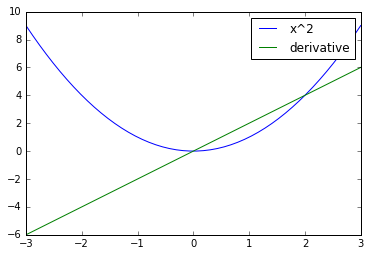

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-3, 3)
x_squared = list(map(fun, x))
x_squared_der = list(map(grad, x))

plt.plot(x, x_squared,label="x^2")
plt.plot(x, x_squared_der, label="derivative")
plt.legend()

# теперь сам

In [25]:
my_vector = T.vector('float64')

#посчитай производные этой функции по my_scalar и my_vector
#warning! Не пытайся понять физический смысл этой функции
weird_psychotic_function = ((my_vector+my_scalar)**(1+T.var(my_vector)) +1./T.arcsinh(my_scalar)).mean()/(my_scalar**2 +1) + 0.01*T.sin(2*my_scalar**1.5)*(T.sum(my_vector)* my_scalar**2)*T.exp((my_scalar-4)**2)/(1+T.exp((my_scalar-4)**2))*(1.-(T.exp(-(my_scalar-4)**2))/(1+T.exp(-(my_scalar-4)**2)))**2

der_by_scalar, der_by_vector = T.grad(weird_psychotic_function, my_scalar), T.grad(weird_psychotic_function, my_vector)

compute_weird_function = theano.function([my_scalar,my_vector],weird_psychotic_function)
compute_der_by_scalar = theano.function([my_scalar,my_vector],der_by_scalar)

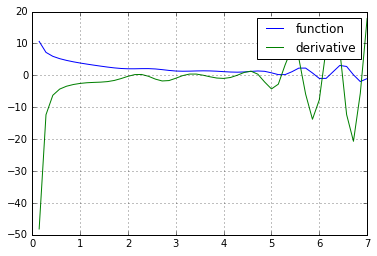

In [26]:
#график функции и твоей производной
vector_0 = [1,2,3]

scalar_space = np.linspace(0,7)

y = [compute_weird_function(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y,label='function')
y_der_by_scalar = [compute_der_by_scalar(x,vector_0) for x in scalar_space]
plt.plot(scalar_space,y_der_by_scalar,label='derivative')
plt.grid();plt.legend()


# Последний штрих - Updates

* updates - это способ изменять значения shared переменных каждый раз В КОНЦЕ вызова функции

* фактически, это словарь {shared_переменная: рецепт нового значения}, который добавляется в функцию при компиляции

Например,

In [27]:
#умножим shared вектор на число и сохраним новое значение обратно в этот shared вектор

inputs = [input_scalar]
outputs = [scalar_times_shared] #вернём вектор, умноженный на число

my_updates = {
    shared_vector_1: scalar_times_shared #и этот же результат запишем в shared_vector_1
}

compute_and_save = theano.function(inputs, outputs, updates=my_updates)

In [28]:
shared_vector_1.set_value(np.arange(5))

#изначальное значение shared_vector_1
print("initial shared value:" ,shared_vector_1.get_value())

# теперь вычислим функцию (значение shared_vector_1 при этом поменяется)
print("compute_and_save(2) returns",compute_and_save(2))

#проверим, что в shared_vector_1
print("new shared value:" ,shared_vector_1.get_value())

initial shared value: [ 0.  1.  2.  3.  4.]
compute_and_save(2) returns [array([ 2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.])]
new shared value: [ 2.  2.  2.  2.  2.  2.  2.  2.  2.  2.]


# Логистическая регрессия
Что нам потребуется:
* Веса лучше хранить в shared-переменной
* Данные можно передавать как input
* Нужно 2 функции:
 * train_function(X,y) - возвращает ошибку и изменяет веса на 1 шаг по граиденту __(через updates)__
 * predict_fun(X) - возвращает предсказанные ответы ("y") по данным

In [29]:
from sklearn.datasets import load_digits
mnist = load_digits(2)

X, y = mnist.data, mnist.target

print ("y [форма - %s]:"%(str(y.shape)), y[:10])
print ("X [форма - %s]:"%(str(X.shape)))
print (X[:3])

y [форма - (360,)]: [0 1 0 1 0 1 0 0 1 1]
X [форма - (360, 64)]:
[[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.
    5.   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.
    0.   8.   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.
   11.   0.   1.  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.
    0.   0.   6.  13.  10.   0.   0.   0.]
 [  0.   0.   0.  12.  13.   5.   0.   0.   0.   0.   0.  11.  16.   9.
    0.   0.   0.   0.   3.  15.  16.   6.   0.   0.   0.   7.  15.  16.
   16.   2.   0.   0.   0.   0.   1.  16.  16.   3.   0.   0.   0.   0.
    1.  16.  16.   6.   0.   0.   0.   0.   1.  16.  16.   6.   0.   0.
    0.   0.   0.  11.  16.  10.   0.   0.]
 [  0.   0.   1.   9.  15.  11.   0.   0.   0.   0.  11.  16.   8.  14.
    6.   0.   0.   2.  16.  10.   0.   9.   9.   0.   0.   1.  16.   4.
    0.   8.   8.   0.   0.   4.  16.   4.   0.   8.   8.   0.   0.   1.
   16.   5.   1.  11.   3.   0.   0.   0.  12.  12.  10. 

In [30]:
# переменные и входы
shared_weights = theano.shared(np.random.randn(X.shape[1]), name="w")
input_X = T.matrix("x", dtype='float64')
input_y = T.vector("y", dtype='float64')

In [31]:
p = 1 / (1 + T.exp(-T.dot(input_X, shared_weights)))
predicted_y = p > 0.5
loss = T.mean(-input_y * T.log(p) - (1 - input_y) * T.log(1 - p))

grad = T.grad(loss, shared_weights)

updates = {
    shared_weights: shared_weights - 0.1 * grad
}

In [32]:
train_function = theano.function(inputs=[input_X, input_y], outputs=loss, updates=updates)
predict_function = theano.function(inputs=[input_X], outputs=predicted_y)

In [33]:
from sklearn.cross_validation import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y)

/usr/local/lib/python3.4/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loss at iter 0:nan
train auc: 0.590909090909
test auc: 0.58
loss at iter 1:nan
train auc: 0.948287220026
test auc: 0.9775
loss at iter 2:nan
train auc: 0.951910408432
test auc: 0.9775
loss at iter 3:nan
train auc: 0.959156785244
test auc: 0.9775
loss at iter 4:nan
train auc: 0.966567852437
test auc: 0.9875
resulting weights:


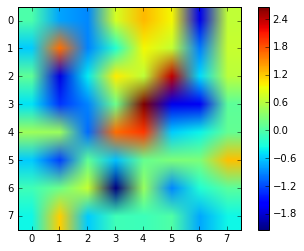

In [34]:
from sklearn.metrics import roc_auc_score

for i in range(5):
    loss_i = train_function(X_train,y_train)
    print ("loss at iter %i:%.4f"%(i,loss_i))
    print ("train auc:",roc_auc_score(y_train, predict_function(X_train)))
    print ("test auc:",roc_auc_score(y_test, predict_function(X_test)))

    
print ("resulting weights:")
plt.imshow(shared_weights.get_value().reshape(8,-1))
plt.colorbar()

# lasagne
* lasagne - это библиотека для написания нейронок произвольной формы на theano
* библиотека низкоуровневая, границы между theano и lasagne практически нет

В качестве демо-задачи выберем то же распознавание чисел, но на большем масштабе задачи
* картинки 28x28
* 10 цифр

In [35]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print(X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)


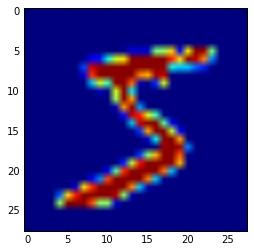

In [36]:
plt.imshow(X_train[0, 0])

In [37]:
import lasagne

input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться")
input_shape = [None, 1, 28, 28]

target_y = T.vector("target Y integer",dtype='int32')

Так задаётся архитектура нейронки

In [38]:
#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape = input_shape, input_var=input_X)

#полносвязный слой, который принимает на вход input layer и имеет 100 нейронов.
# нелинейная функция - сигмоида как в логистической регрессии
# слоям тоже можно давать имена, но это необязательно
dense_1 = lasagne.layers.DenseLayer(input_layer, num_units=50,
                                   nonlinearity = lasagne.nonlinearities.sigmoid,
                                   name="hidden_dense_layer")

#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(dense_1, num_units=10,
                                        nonlinearity = lasagne.nonlinearities.softmax,
                                        name="output")


In [39]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [40]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print(all_weights)

[hidden_dense_layer.W, hidden_dense_layer.b, output.W, output.b]


### дальше вы могли бы просто
* задать функцию ошибки вручную
* посчитать градиент ошибки по all_weights
* написать updates
* но это долго, а простой шаг по градиенту - не самый лучший смособ оптимизировать веса

Вместо этого, опять используем lasagne

In [41]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()


accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.rmsprop(loss, all_weights,learning_rate=0.01)

In [42]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates=updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

### Вот и всё, пошли её учить
* данных теперь много, поэтому лучше учиться стохастическим градиентным спуском
* для этого напишем функцию, которая бьёт выпорку на мини-батчи (в обычном питоне, не в theano)

In [43]:
# вспомогательная функция, которая возвращает список мини-батчей для обучения нейронки

#на вход
# X - тензор из картинок размером (много, 1, 28, 28), например - X_train
# y - вектор из чиселок - ответов для каждой картинки из X; например - Y_train
#batch_size - одно число - желаемый размер группы

#что нужно сделать
# 1) перемешать данные
# - важно перемешать X и y одним и тем же образом, чтобы сохранить соответствие картинки ответу на неё
# 3) побить данные на подгруппы так, чтобы в каждой подгруппе было batch_size картинок и ответов
# - если число картинок не делится на batch_size, одну подгруппу можно вернуть другого размера
# 4) вернуть список (или итератор) пар:
# - (подгруппа картинок, ответы из y на эту подгруппу)
def iterate_minibatches(inputs, targets, batchsize, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

# Процесс обучения

In [44]:
import time

num_epochs = 100 #количество проходов по данным

batch_size = 50 #размер мини-батча

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 100 took 0.861s
  training loss (in-iteration):		0.288530
  train accuracy:		91.58 %
  validation accuracy:		95.73 %
Epoch 2 of 100 took 0.807s
  training loss (in-iteration):		0.143800
  train accuracy:		95.65 %
  validation accuracy:		95.89 %
Epoch 3 of 100 took 0.822s
  training loss (in-iteration):		0.112296
  train accuracy:		96.60 %
  validation accuracy:		96.46 %
Epoch 4 of 100 took 1.091s
  training loss (in-iteration):		0.095066
  train accuracy:		97.09 %
  validation accuracy:		96.44 %
Epoch 5 of 100 took 0.803s
  training loss (in-iteration):		0.082004
  train accuracy:		97.45 %
  validation accuracy:		96.53 %
Epoch 6 of 100 took 1.011s
  training loss (in-iteration):		0.071790
  train accuracy:		97.77 %
  validation accuracy:		96.45 %
Epoch 7 of 100 took 0.802s
  training loss (in-iteration):		0.063565
  train accuracy:		98.01 %
  validation accuracy:		96.40 %
Epoch 8 of 100 took 1.022s
  training loss (in-iteration):		0.057168
  train accuracy:		98.27 %
  valida

In [45]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: колдун 80 уровня")
else:
    print ("Нужно больше магии!")

Final results:
  test accuracy:		96.80 %
Нужно больше магии!


# Нейронка твоей мечты


* Задача - сделать нейронку, которая получит точность 99% на валидации (validation accuracy)
 * __+1 балл__ за каждые 0.2% сверх 99%
 * Вариант "is fine too" - 97.5%. 
 * Чем выше, тем лучше.
 
__ В конце есть мини-отчётик, который имеет смысл прочитать вначале и заполнять по ходу работы. __
 

## Что можно улучшить:



 * размер сети
   * бОльше нейронов, 
   * бОльше слоёв, 
   * почти наверняка нужны свёртки
   * Пх'нглуи мглв'нафх Ктулху Р'льех вгах'нагл фхтагн! 
   
   
   
 * регуляризация - чтобы не переобучалось
   * приплюсовать к функции ошибки какую-нибудь сумму квадратов весов
   * можно сделать вручную, а можно - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   
   
   
 * Метод оптимизации - rmsprop, nesterov_momentum, adadelta, adagrad и т.п.
   * сходятся быстрее и иногда - к лучшему оптимуму
   * имеет смысл поиграть с размером батча, количеством эпох и скоростью обучения
   
   
   
 * Dropout - для борьбы с переобучением
   * `lasagne.layers.DropoutLayer(предыдущий_слой, p=вероятность_занулить)`
   
   
   
 * Свёрточные слои 
   * `network = lasagne.layers.Conv2DLayer(предыдущий_слой,`
    `                       num_filters = число нейронов,`
    `                        filter_size = (ширина_квадрата, высота_квадрата),`
    `                        nonlinearity = нелинейная_функция)`
   * ВАРНУНГ! могут учиться долго на CPU
     * Однако мы всё равно рекоммендуем обучить хотя бы маленькую свёртку
 
 * Любые другие слои и архитектуры
   * http://lasagne.readthedocs.org/en/latest/modules/layers.html
   * Pooling, Batch Normalization, etc
   
   
 * Наконец, можно поиграть с нелинейностями в скрытых слоях
   * tanh, relu, leaky relu, etc
 
 
   
Для удобства, ниже есть заготовка решения, которое можно заполнять, а можно выкинуть и написать своё

In [140]:
from mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

print(X_train.shape, y_train.shape)

(50000, 1, 28, 28) (50000,)


In [141]:
import lasagne

input_X = T.tensor4("X")

#размерность входа (None означает "может изменяться")
input_shape = [None, 1, 28, 28]

target_y = T.vector("target Y integer",dtype='int32')

In [142]:
#входной слой (вспомогательный)
input_layer = lasagne.layers.InputLayer(shape = input_shape, input_var=input_X)

nn = lasagne.layers.Conv2DLayer(input_layer, num_filters=20, filter_size=(5, 5), 
                                nonlinearity=lasagne.nonlinearities.rectify, pad='same')

nn = lasagne.layers.MaxPool2DLayer(nn, pool_size=(2, 2), stride=(2, 2))

nn = lasagne.layers.Conv2DLayer(nn, num_filters=50, filter_size=(5, 5), 
                                nonlinearity=lasagne.nonlinearities.rectify, pad='same')

nn = lasagne.layers.MaxPool2DLayer(nn, pool_size=(2, 2), stride=(2, 2))

nn = lasagne.layers.FlattenLayer(nn)

nn = lasagne.layers.DenseLayer(nn, num_units=256, nonlinearity=lasagne.nonlinearities.tanh)

nn = lasagne.layers.DenseLayer(nn, num_units=64, nonlinearity=lasagne.nonlinearities.tanh)

#ВЫХОДНОЙ полносвязный слой, который принимает на вход dense_1 и имеет 10 нейронов -по нейрону на цифру
#нелинейность - softmax - чтобы вероятности всех цифр давали в сумме 1
dense_output = lasagne.layers.DenseLayer(nn, num_units = 10,
                                        nonlinearity=lasagne.nonlinearities.softmax,
                                        name='output')


In [143]:
#предсказание нейронки (theano-преобразование)
y_predicted = lasagne.layers.get_output(dense_output)

In [144]:
#все веса нейронки (shared-переменные)
all_weights = lasagne.layers.get_all_params(dense_output)
print(all_weights)

[W, b, W, b, W, b, W, b, output.W, output.b]


In [145]:
#функция ошибки - средняя кроссэнтропия
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#<возможно добавить регуляризатор>

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#сразу посчитать словарь обновлённых значений с шагом по градиенту, как раньше
updates_sgd = lasagne.updates.adam(loss, all_weights)

In [146]:
#функция, которая обучает сеть на 1 шаг и возвращащет значение функции потерь и точности
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)

#функция, которая считает точность
accuracy_fun = theano.function([input_X,target_y],accuracy)

In [147]:
from tqdm import tqdm

#итерации обучения

num_epochs = 50

batch_size = 1024

for epoch in tqdm(range(num_epochs)):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

  2%|▏         | 1/50 [00:35<28:50, 35.31s/it]

Epoch 1 of 50 took 35.309s
  training loss (in-iteration):		0.577836
  train accuracy:		83.37 %
  validation accuracy:		95.49 %


  4%|▍         | 2/50 [01:10<28:12, 35.26s/it]

Epoch 2 of 50 took 35.158s
  training loss (in-iteration):		0.138169
  train accuracy:		96.02 %
  validation accuracy:		97.45 %


  6%|▌         | 3/50 [01:45<27:35, 35.23s/it]

Epoch 3 of 50 took 35.145s
  training loss (in-iteration):		0.084029
  train accuracy:		97.57 %
  validation accuracy:		98.06 %


  8%|▊         | 4/50 [02:20<26:57, 35.17s/it]

Epoch 4 of 50 took 35.041s
  training loss (in-iteration):		0.063105
  train accuracy:		98.15 %
  validation accuracy:		98.29 %


 10%|█         | 5/50 [02:55<26:20, 35.13s/it]

Epoch 5 of 50 took 35.016s
  training loss (in-iteration):		0.047532
  train accuracy:		98.66 %
  validation accuracy:		98.54 %


 12%|█▏        | 6/50 [03:31<25:48, 35.20s/it]

Epoch 6 of 50 took 35.379s
  training loss (in-iteration):		0.041279
  train accuracy:		98.81 %
  validation accuracy:		98.69 %


 14%|█▍        | 7/50 [04:06<25:13, 35.19s/it]

Epoch 7 of 50 took 35.165s
  training loss (in-iteration):		0.033090
  train accuracy:		99.05 %
  validation accuracy:		98.90 %


 16%|█▌        | 8/50 [04:41<24:34, 35.11s/it]

Epoch 8 of 50 took 34.917s
  training loss (in-iteration):		0.025918
  train accuracy:		99.26 %
  validation accuracy:		98.74 %


 18%|█▊        | 9/50 [05:16<23:57, 35.06s/it]

Epoch 9 of 50 took 34.960s
  training loss (in-iteration):		0.021879
  train accuracy:		99.42 %
  validation accuracy:		98.73 %


 20%|██        | 10/50 [05:50<23:20, 35.01s/it]

Epoch 10 of 50 took 34.887s
  training loss (in-iteration):		0.018979
  train accuracy:		99.48 %
  validation accuracy:		99.00 %


 22%|██▏       | 11/50 [06:25<22:43, 34.97s/it]

Epoch 11 of 50 took 34.885s
  training loss (in-iteration):		0.016577
  train accuracy:		99.53 %
  validation accuracy:		99.01 %


 24%|██▍       | 12/50 [07:00<22:09, 34.98s/it]

Epoch 12 of 50 took 35.002s
  training loss (in-iteration):		0.012848
  train accuracy:		99.69 %
  validation accuracy:		99.10 %


 26%|██▌       | 13/50 [07:35<21:31, 34.91s/it]

Epoch 13 of 50 took 34.726s
  training loss (in-iteration):		0.011742
  train accuracy:		99.72 %
  validation accuracy:		99.13 %


 28%|██▊       | 14/50 [08:10<20:59, 34.98s/it]

Epoch 14 of 50 took 35.150s
  training loss (in-iteration):		0.008943
  train accuracy:		99.81 %
  validation accuracy:		99.01 %


 30%|███       | 15/50 [08:45<20:20, 34.86s/it]

Epoch 15 of 50 took 34.588s
  training loss (in-iteration):		0.006841
  train accuracy:		99.86 %
  validation accuracy:		99.05 %


 32%|███▏      | 16/50 [09:20<19:47, 34.91s/it]

Epoch 16 of 50 took 35.037s
  training loss (in-iteration):		0.006735
  train accuracy:		99.87 %
  validation accuracy:		99.01 %


 34%|███▍      | 17/50 [09:55<19:12, 34.94s/it]

Epoch 17 of 50 took 34.991s
  training loss (in-iteration):		0.006369
  train accuracy:		99.85 %
  validation accuracy:		99.12 %


 36%|███▌      | 18/50 [10:30<18:39, 34.98s/it]

Epoch 18 of 50 took 35.074s
  training loss (in-iteration):		0.004508
  train accuracy:		99.93 %
  validation accuracy:		99.14 %


 38%|███▊      | 19/50 [11:05<18:03, 34.94s/it]

Epoch 19 of 50 took 34.845s
  training loss (in-iteration):		0.003716
  train accuracy:		99.95 %
  validation accuracy:		98.93 %


 40%|████      | 20/50 [11:40<17:27, 34.93s/it]

Epoch 20 of 50 took 34.906s
  training loss (in-iteration):		0.004318
  train accuracy:		99.92 %
  validation accuracy:		99.02 %


 42%|████▏     | 21/50 [12:16<17:03, 35.29s/it]

Epoch 21 of 50 took 36.145s
  training loss (in-iteration):		0.003599
  train accuracy:		99.94 %
  validation accuracy:		99.01 %


 44%|████▍     | 22/50 [12:51<16:27, 35.27s/it]

Epoch 22 of 50 took 35.204s
  training loss (in-iteration):		0.002117
  train accuracy:		99.98 %
  validation accuracy:		99.08 %


 46%|████▌     | 23/50 [13:26<15:51, 35.22s/it]

Epoch 23 of 50 took 35.124s
  training loss (in-iteration):		0.001806
  train accuracy:		99.98 %
  validation accuracy:		99.05 %


 48%|████▊     | 24/50 [14:01<15:13, 35.12s/it]

Epoch 24 of 50 took 34.889s
  training loss (in-iteration):		0.001456
  train accuracy:		99.99 %
  validation accuracy:		99.14 %


 50%|█████     | 25/50 [14:36<14:36, 35.05s/it]

Epoch 25 of 50 took 34.888s
  training loss (in-iteration):		0.001169
  train accuracy:		99.99 %
  validation accuracy:		99.16 %


 52%|█████▏    | 26/50 [15:11<14:01, 35.08s/it]

Epoch 26 of 50 took 35.130s
  training loss (in-iteration):		0.001191
  train accuracy:		99.99 %
  validation accuracy:		99.13 %


 54%|█████▍    | 27/50 [15:46<13:26, 35.07s/it]

Epoch 27 of 50 took 35.054s
  training loss (in-iteration):		0.000986
  train accuracy:		100.00 %
  validation accuracy:		99.21 %


 56%|█████▌    | 28/50 [16:21<12:49, 34.99s/it]

Epoch 28 of 50 took 34.787s
  training loss (in-iteration):		0.000841
  train accuracy:		100.00 %
  validation accuracy:		99.11 %


 58%|█████▊    | 29/50 [16:56<12:16, 35.09s/it]

Epoch 29 of 50 took 35.335s
  training loss (in-iteration):		0.000943
  train accuracy:		99.99 %
  validation accuracy:		99.15 %


 60%|██████    | 30/50 [17:32<11:43, 35.16s/it]

Epoch 30 of 50 took 35.333s
  training loss (in-iteration):		0.000689
  train accuracy:		100.00 %
  validation accuracy:		99.08 %


 62%|██████▏   | 31/50 [18:07<11:10, 35.28s/it]

Epoch 31 of 50 took 35.558s
  training loss (in-iteration):		0.000570
  train accuracy:		100.00 %
  validation accuracy:		99.23 %


KeyboardInterrupt: 

In [148]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

Final results:
  test accuracy:		99.23 %


Отчётик, примерный его вид.

Творческий подход приветствуется, но хотелось бы узнать про следующие вещи:
* идея
* краткая история правок
* как выглядит сеть и почему
* каким методом обучается и почему
* регуляризована ли и как

Строгих математических выводов от вас никто не ждёт, вариант 
 * "Попробовал так, получилось лучше, чем вот-так, а тот третий вариант по названию не понравился" - не предел мечты, но __ок__
 * "Почитал такие статьи, сделал такие эксперименты, пришёл к такому выводу" - __идеально_
 * "сделал так, потому что в вон-той демке другой чувак так сделал, но тебе об этом не скажу, а придумаю какую-нибудь наукообразную чушь" - __не ок__

### Привет, я Голованов Сергей, и я не алкоголик

Когда-то давно, когда трава была зеленее, а до дедлайна ещё оставалось больше часа, мне в голову пришла идея:

##### А давай, я сделаю нейронку, которая вжух и зафитится на мнисте.
Начнем с архитекуры LeNet (или что-то типо того), т.к. она была разработана для работы с мнистом.
Оптимизатор - adam, ибо он the best.

##### Изменения
После 12 эпох с размером батча 1024 получилось 90.07%, а потом аккураси начал убывать потихоньку. Но нам этого мало!

Уменьшил число нейронов в предпоследнем слое с 512 до 256, т.к. учится быстрее, а результат поменялся не сильно.

Попробывал заменить функции активации c ReLU на LeakyReLU. Результат лучше не стал.

Попробывал заменить ReLU в предпоследнем слое на tanh. Стало чуточку лучше.

Добавил еще один полносвязный слой с 64мя нейронами.

##### И вот, спустя  5  попыток, на свет появилась топология сети:

input_layer = lasagne.layers.InputLayer(shape = input_shape, input_var=input_X)

nn = lasagne.layers.Conv2DLayer(input_layer, num_filters=20, filter_size=(5, 5),
                                nonlinearity=lasagne.nonlinearities.rectify, pad='same')
                                
nn = lasagne.layers.MaxPool2DLayer(nn, pool_size=(2, 2), stride=(2, 2))

nn = lasagne.layers.Conv2DLayer(nn, num_filters=50, filter_size=(5, 5), 
                                nonlinearity=lasagne.nonlinearities.rectify, pad='same')
                                
nn = lasagne.layers.MaxPool2DLayer(nn, pool_size=(2, 2), stride=(2, 2))

nn = lasagne.layers.FlattenLayer(nn)

nn = lasagne.layers.DenseLayer(nn, num_units=256, nonlinearity=lasagne.nonlinearities.tanh)

nn = lasagne.layers.DenseLayer(nn, num_units=64, nonlinearity=lasagne.nonlinearities.tanh)

dense_output = lasagne.layers.DenseLayer(nn, num_units = 10,
                                        nonlinearity=lasagne.nonlinearities.softmax,
                                        name='output')


Которая после ~20 минут обучения дала-таки точность

100% точность - на обучении

99.23 % точность - на валидации

99.23 % точность - на тесте